## SuperResolution CNN: Description and Introduction

The goal of super resolution is to recover and/or generate a high-resolution image from a low-resolution input. This can be useful in various applications, but I find restoring old photos or upscaling graphics of old video games the most exciting. Also, I've already seen some examples of restoring historical video footages, that look pretty awesome - and I'm sure SRCNNs can do great job in restoring old footages and remastering old movies.

The main problem with this task is that while upscaling an image we cannot get missing pixels from nowhere. In information theory, this is called the "Data Processing Inequality." This is where neural networks come in handy, as they can hallucinate missing data and fill in missing pixels.

To accomplish this task, we will be developing the Super-Resolution Convolutional Neural Network (SRCNN). This network was introduced in the paper "Image Super-Resolution Using Deep Convolutional Networks" published in 2014. The paper is available here: https://arxiv.org/abs/1501.00092

SRCNN is a deep convolutional neural network that learns an end-to-end mapping of low-resolution to high-resolution images. As a result, we can use it to improve the image quality of low-resolution images. To evaluate the performance of this network, we will be using Mean Squared Error (MSE). However, during implementation, I discovered that MSE does not correlate well with human perception. Despite this, I decided to use it for its simplicity.

In this project, we will be using the classic SRCNN with slight modifications. However, since this architecture was introduced 10 years ago, more advanced approaches to super resolution have been developed. For example, solutions to the MSE problem mentioned above include custom loss functions or perceptual loss functions. Perceptual loss functions aim to capture high-level perceptual differences between images by comparing features extracted from a pre-trained neural network (such as VGG).

Additionally, Generative Adversarial Networks (GANs) use two competing networks: one for predicting upscaled images and another for distinguishing between predicted and original images. These two networks are trained simultaneously through a process where they compete against each other, showing good results in networks like SRGAN. SRGAN developers have also worked with more complex network architectures and experimental solutions, such as avoiding batch normalization and enhancing custom loss functions to use both VGG-based loss functions and MSE in a balanced way.

Due to time constraints (I had only 2 days to work on this project), I decided to take an already implemented solution, rewrite it using the approaches and techniques learned throughout the course, and study ways of potential improvement. The project I used as an example can be found here: https://github.com/MaokeAI/SRCNN-keras

Here is what I'm going to do in this project:

* Load necessary libraries. 
* Define loss measurements. I decided to stick with MSE.
* Rescale our training set once to create degraded images with a downscale factor of 2.
* Check the dataset to plan future image resizing/modifications and evaluate visual differences between reference and target images.
* Create data generators to work with our training/validation data.
* Convert the RGB and BGR color spaces to YCrCb since the Y dimension (luminance) is what we will train our network on.
* Build deep neural networks in Keras, train them, and plot the accuracy.
* Implement necessary crop modifications to images.
* Deploy and evaluate the SRCNN prediction network.



### 1. Imports

We're going to use Keras as it's simple and beautiful :)

In [2]:
# import the necessary packages
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os

# python magic function, displays pyplot figures in the notebook
%matplotlib inline

### 2. Image Quality Metrics

To start, lets define a couple of functions that we can use to calculate MSE. We will need it here and there during the application and even though it doesn't correspond well to visual perception it does it's job as training loss function.

In [3]:
# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err


### 3. Preparing Images

For this project, I've decided NOT to use the same images that were used in the original SRCNN paper. I've created a dataset based on pictures of Abyssinian cats from this dataset: https://www.kaggle.com/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset I've randomly split it on  train/val/test and adjusted number of pics there based on my intuition and few demo launches of my nerual network.

Now that we have some images, we want to produce low resolution versions of these same images.  We can accomplish this by resizing the images, both downwards and upwards, using OpenCV. We will be using bilinear interpolation. So these images will be our training data as well as our base method for comparison: after neural network is trained we will compare it's results by MSE metrics (and visually) with this images.

Once we produce these low resolution images, we will save them in a new folder. I've already supplied this as test_x, val_x, train_x folders so this code is commented out.

In [4]:
# prepare and save low resolution images by introducing quality distortions via resizing

def prepare_images(path, purpose, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        if img is None:
            continue
        h, w, _ = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('pets_images/{}/{}'.format(purpose, file), img)

In [5]:
# prepare_images('pets_images/train_y/', 'train_x', 2)
# prepare_images('pets_images/val_y/', 'val_x', 2)
# prepare_images('pets_images/test_y/', 'test_x', 2)

### 4. Testing Low Resolution Images

To ensure that our image quality metrics are being calculated correctly and that the images were effectively degraded, lets calculate the MSE between our reference images and the degraded images that we just prepared. Also it's time to see some random pictures and analyse dataset: what we see are colorful images with various intensity and, most important, different sizes! Later we will figure out architectural solution for an input layer: to resize images to train the network and not to resize them to do a pure testing for test dataset.

Also we see that even that we've done same thing to all the images, MSE values are dramatically different.

Number of files in train category: 160
Number of files in validation category: 24
Number of files in test category: 15


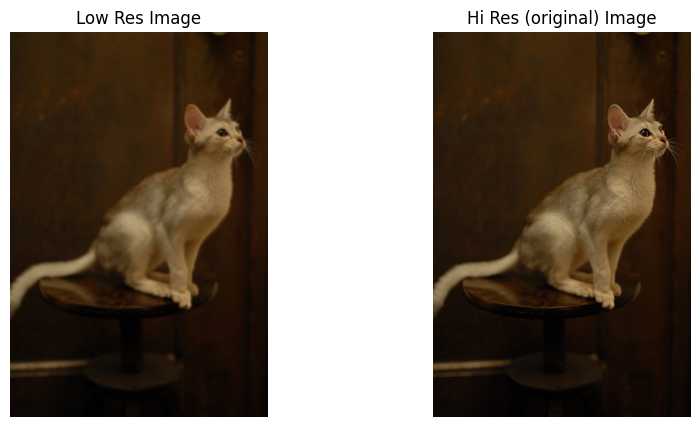

MSE for Abyssinian_46.jpg: 26.10826865671642


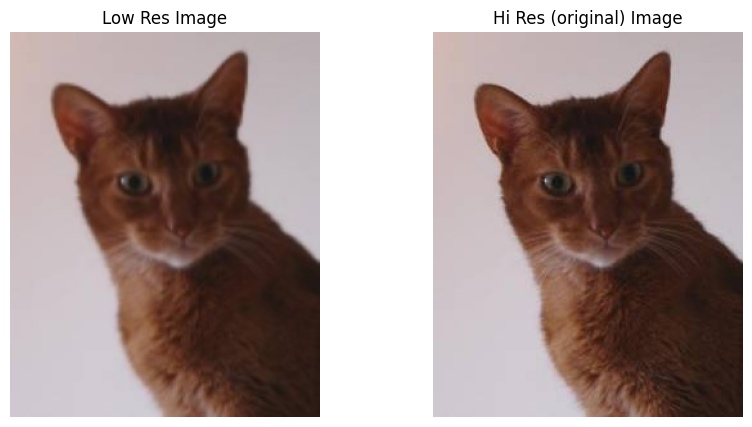

MSE for Abyssinian_210.jpg: 25.070871369294604


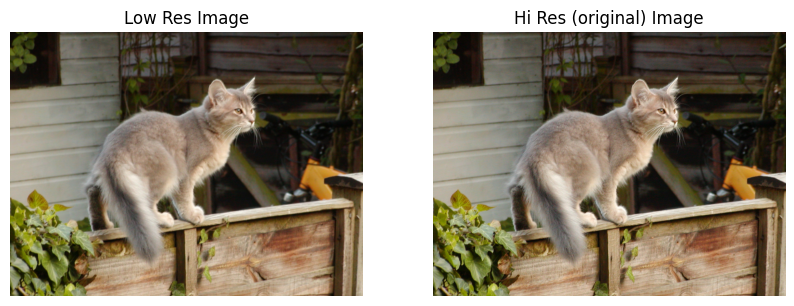

MSE for Abyssinian_170.jpg: 35.3423625


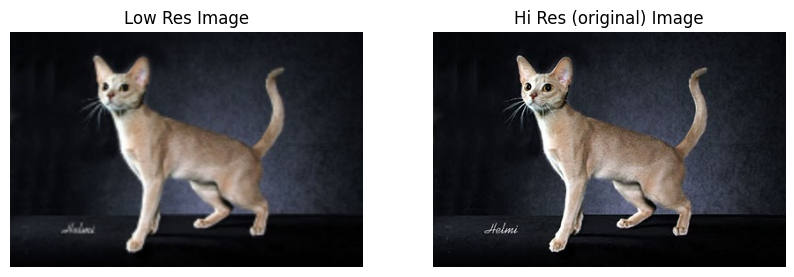

MSE for Abyssinian_73.jpg: 161.84284644194756


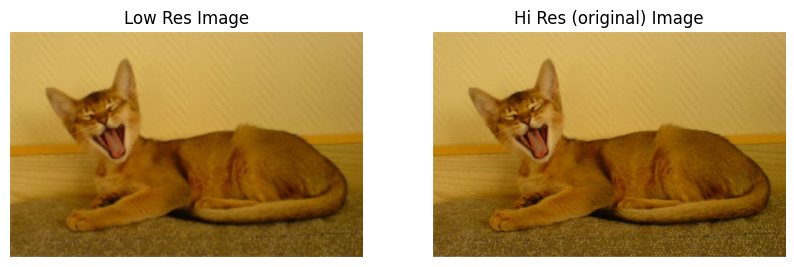

MSE for Abyssinian_155.jpg: 32.829622687902166


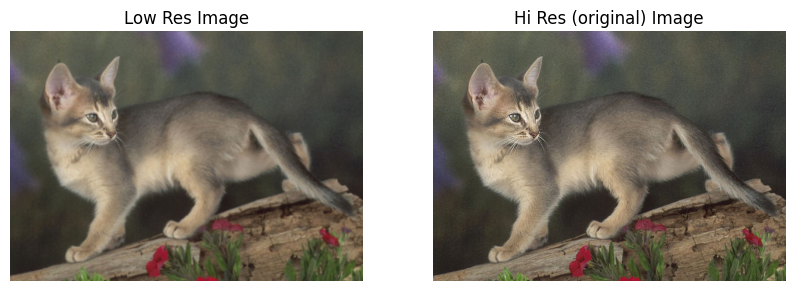

MSE for Abyssinian_133.jpg: 81.5228629032258


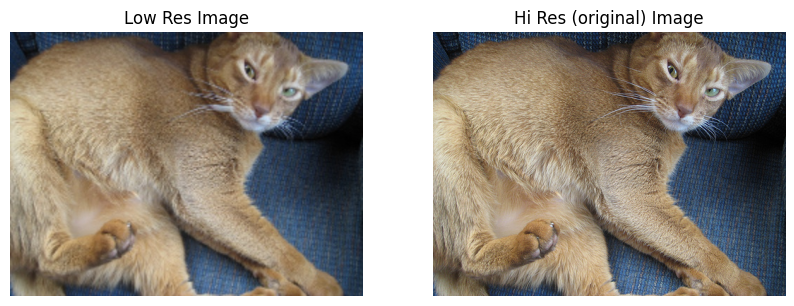

MSE for Abyssinian_93.jpg: 576.165648


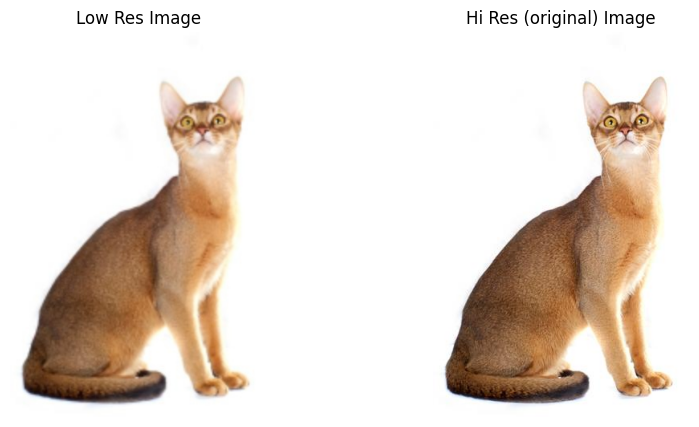

MSE for Abyssinian_66.jpg: 87.73194010416667


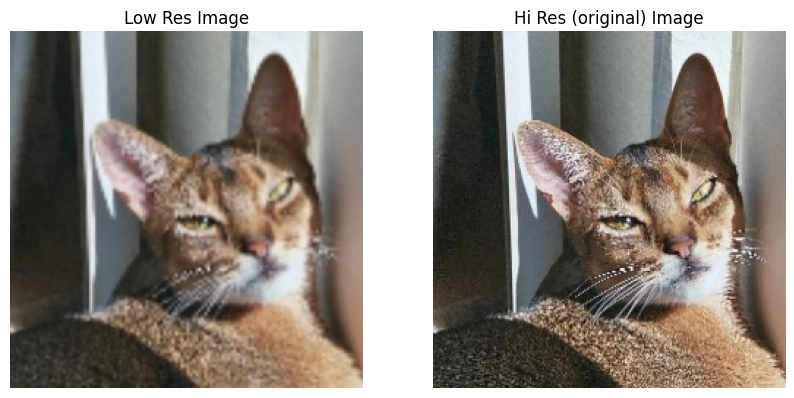

MSE for Abyssinian_217.jpg: 645.1870450989728


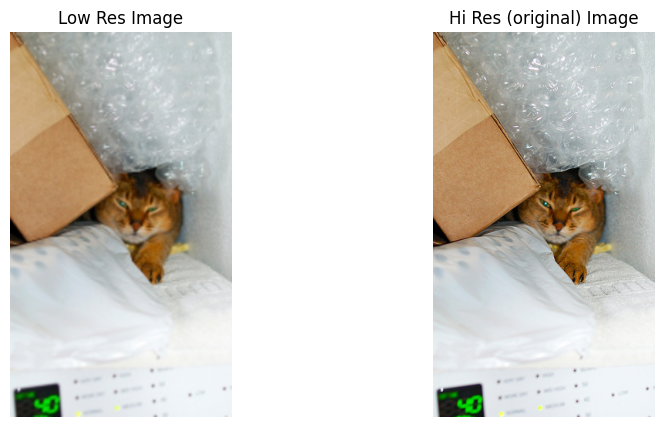

MSE for Abyssinian_76.jpg: 156.35391666666666


In [6]:
import random

# test the generated images using the image quality metrics

# get a list of all files in the images folder
files_train = os.listdir('pets_images/train_x/')
files_val = os.listdir('pets_images/val_x/')
files_test = os.listdir('pets_images/test_x/')

print("Number of files in train category:", len(files_train))
print("Number of files in validation category:", len(files_val))
print("Number of files in test category:", len(files_test))

# select 10 random images from the list
random_files = random.sample(files_train, 10)

# iterate over the selected random files
for file in random_files:
    
    # open target and reference images
    lr = cv2.imread('pets_images/train_x/{}'.format(file))
    ref = cv2.imread('pets_images/train_y/{}'.format(file))
    
    # calculate score
    score = mse(lr, ref)

    # print the MSE score for each image
    # plot target and ref images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(lr, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Low Res Image')
    axes[0].axis('off')
    axes[1].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Hi Res (original) Image')
    axes[1].axis('off')
    plt.show()
    print('MSE for {}: {}'.format(file, score))

### 5. Data generators

Now we'll need data generators to feed train data in portions into our network. I've created 2 data generators: one for training that splits image into patches and one for validation that provides entire images.

In [6]:
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
# BORDER_CUT = 8
BLOCK_STEP = 16
BLOCK_SIZE = 32


def crop_data_generator(path_hr, path_lr, batch_size):
    names = os.listdir(path_hr)
    names = sorted(names)
    nums = names.__len__()

    while True:
        for i in range(0, nums, batch_size):
            data = []
            label = []

            for j in range(i, min(i + batch_size, nums)):
                hr_name = path_hr + names[j]
                hr_img = cv2.imread(hr_name, cv2.IMREAD_COLOR)
                hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
                hr_img = hr_img[:, :, 0]
                shape = hr_img.shape

                lr_name = path_lr + names[j]
                lr_img = cv2.imread(lr_name, cv2.IMREAD_COLOR)
                lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2YCrCb)
                lr_img = lr_img[:, :, 0]

                width_num = (shape[0] - BLOCK_SIZE + BLOCK_STEP) // BLOCK_STEP
                height_num = (shape[1] - BLOCK_SIZE + BLOCK_STEP) // BLOCK_STEP
                for k in range(width_num):
                    for l in range(height_num):
                        x = k * BLOCK_STEP
                        y = l * BLOCK_STEP
                        hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                        lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]

                        lr_patch = lr_patch.astype(float) / 255.
                        hr_patch = hr_patch.astype(float) / 255.

                        lr = np.zeros((1, Patch_size, Patch_size), dtype=np.double)
                        hr = np.zeros((1, label_size, label_size), dtype=np.double)

                        lr[0, :, :] = lr_patch
                        hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                        data.append(lr)
                        label.append(hr)

            data = np.array(data, dtype=float)
            label = np.array(label, dtype=float)
            train_data = np.transpose(data, (0, 2, 3, 1))
            train_label = np.transpose(label, (0, 2, 3, 1))
            yield train_data, train_label




def data_generator(path_hr, path_lr, batch_size):
    names = os.listdir(path_hr)
    names = sorted(names)
    nums = names.__len__()

    while True:
        for i in range(0, nums, batch_size):
            data = []
            label = []

            for j in range(i, min(i + batch_size, nums)):
                hr_name = path_hr + names[j]
                hr_img = cv2.imread(hr_name, cv2.IMREAD_COLOR)
                hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
                hr_img = hr_img[:, :, 0]
                shape = hr_img.shape

                lr_name = path_lr + names[j]
                lr_img = cv2.imread(lr_name, cv2.IMREAD_COLOR)
                lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2YCrCb)
                lr_img = lr_img[:, :, 0]

                width_num = int((shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
                height_num = int((shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
                for k in range(width_num):
                    for l in range(height_num):
                        x = k * BLOCK_STEP
                        y = l * BLOCK_STEP
                        hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                        lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]

                        lr_patch = lr_patch.astype(float) / 255.
                        hr_patch = hr_patch.astype(float) / 255.

                        lr = np.zeros((1, Patch_size, Patch_size), dtype=np.double)
                        hr = np.zeros((1, label_size, label_size), dtype=np.double)

                        lr[0, :, :] = lr_patch
                        hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                        data.append(lr)
                        label.append(hr)

            data = np.array(data, dtype=float)
            label = np.array(label, dtype=float)
            train_data = np.transpose(data, (0, 2, 3, 1))
            train_label = np.transpose(label, (0, 2, 3, 1))
            yield train_data, train_label

### 6. Building the SRCNN Model

Now that we have our low resolution images (train set) and data generators we can start building the SRCNN. The achitecture and hyper parameters of the SRCNN network can be obtained from the original paper referenced above. 

I was surprised not to see separate Input layer and final Dense/Flatten layers that we used during our course. But since I was rewriting it anyway, I've added the input layer (of course it was there anyway, just not specified explicitly) :) Also I've realized that final Conv2D layer is working like a Dense layer here with it's 1 filter and linear activation. 

Also it's worth to mention that original code used Sequential instead of Model but I've decided to use what I've learned in the course and seems it worked.

In [8]:
inputs = Input(shape=(32, 32, 1))

net = Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True)(inputs)
net = Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True)(net)
outputs = Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True)(net)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 24, 24, 128)    │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 1)      │         1,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,889 (335.50 KB)

 Trainable params: 85,889 (335.50 KB)

 Non-trainable params: 0 (0.00 B)

### 7. Training the model 

Author of github project that I've took as an example, trained his network for 200 epochs on 91 images. I was surprised that he didn't face any overfitting. But since no anti-overfitting technics were used there, seems like it isn't a big problem for chosen parameters. Also I was surprised that he found only 91 images enough to train...

Anyway, having limited time and no GPU (seems like NPU of my Intel Core Ultra can't be used to train models :( )) I've tried with Google Colab - and was getting  Out of Memory (GPU) and Maximum Tensor size (TPU) exceptions. 

But since I've already tested it on 5 epochs on smaller dataset and seen that even such a little training ends up in profit (at least visually), I've decided to stick with 25 epochs (few hours of training time on my CPU) with batch size of 16 and dataset of 160 training + 24 validation images. Even though I understood that profit in MSE might be small, I've decided to perform it anyway and compare it with result that I got with weights provided on github (https://github.com/MaokeAI/SRCNN-keras)

In [9]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    

In [10]:
epochs = 25
batch_size = 16

model.compile(loss="mse", optimizer="adam", metrics=["mean_squared_error"])

checkpoint = ModelCheckpoint("SRCNN_check.keras", monitor='val_loss', verbose=0, save_best_only=True,
                                 save_weights_only=False, mode='min')
callbacks_list = [checkpoint]

len_x_train = len(os.listdir('pets_images/train_x/'))
len_x_val = len(os.listdir('pets_images/val_x/'))

history = model.fit(crop_data_generator('pets_images/train_y/', 'pets_images/train_x/',  batch_size),
                    steps_per_epoch=len_x_train//batch_size, epochs=epochs,
                    validation_data=data_generator('pets_images/val_y/', 'pets_images/val_x/', batch_size),
                    validation_steps=len_x_val//batch_size, callbacks=callbacks_list)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 247s 26s/step - loss: 0.1345 - mean_squared_error: 0.1345 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 321s 32s/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 273s 26s/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 283s 28s/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 252s 25s/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 269s 27s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 268s 26s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.00

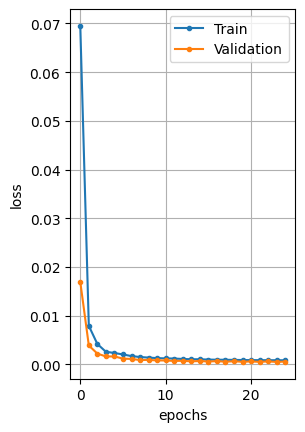

In [11]:
plot_history(history)

### 8. Image crop

 These little functions below are necessary to make sure our images are equal in size. modcrop() function modifies the dimensions of an image so that they are evenly divisible by a given scale factor. shave() function crops the borders of an image by a specified number of pixels.

In [12]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

### 9. Define prediction model

Here the interesting technic is applied. A separate model is defined with same parameters like a training model but with a different input: shape=(None, None, 1). This allows our network to accept images of various sizes during inference.

In [9]:
def predict_model():
        inputs = Input(shape=(None, None, 1))
        net = Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True)(inputs)
        net = Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True)(net)
        outputs = Conv2D(filters=1, kernel_size=(5, 5), kernel_initializer='glorot_uniform',
                         activation='linear', padding='valid', use_bias=True)(net)
        model = Model(inputs, outputs)
        model.compile(optimizer="adam", loss='mean_squared_error', metrics=['mean_squared_error'])
        return model

### 10. Deploying the SRCNN

Here we load weights from previously trained model (or the ones we dowloaded).
Further, it will be necessary to preprocess the images extensively before using them as inputs to the network.  This processing will include cropping, color space conversions and normalization. I've decided to add PSNR to the output just to have more than 1 metric. But in fact, I already had more than 1: visual difference between our "x" and "y" are obvious!

In [10]:
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = predict_model()
    srcnn.load_weights('SRCNN_check_25ep_16bs_160tr_24val.keras')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('pets_images/test_y/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations

    scores = []
    scores.append([cv2.PSNR(degraded, ref), mse(degraded, ref)])
    scores.append([cv2.PSNR(output, ref), mse(output, ref)])
    
    # return images and scores
    return ref, degraded, output, scores

### 11. Save the results

Now it's time to save the results. We're going to visualize them side by side: original, degraded and predicted as well as MSE and PSNR. Luckily visual difference is obvious, since metrics didn't work too well :(

In [13]:
for file in os.listdir('pets_images/test_x/'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('pets_images/test_x/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {}'.format(scores[0][0], scores[0][1]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {}'.format(scores[1][0], scores[1][1]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('pets_images/output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
Saving Abyssinian_116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Saving Abyssinian_117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
Saving Abyssinian_118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Saving Abyssinian_120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Saving Abyssinian_121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Saving Abyssinian_122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Saving Abyssinian_124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Saving Abyssinian_125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Saving Abyssinian_126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Saving Abyssinian_127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Saving Abyssinian_128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Saving Abyssinian_129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
Saving Abyssinian_130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Saving Abyssinian_131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Saving Abyssinian_132.jpg


### 12. Results and Conclusions

Visually I can see that even my 5 epoch test run is giving some improvement to degraded images. Trained on 25 epochs network gives decent results, clearly visible by eye. But when it comes to MSE the performance is not obvious. I've calculated average MSE for 10 images and it goes as following:

* Pre-trained network - weights from github (200 epochs, 91 imaages): 136
* Bicubic interpolation, resize: 171
* Main training run. 25 epochs, 160 + 24 images: 174
* Test training run. 5 epochs, 60 + 10 images: 183

This average result is heavily driven by few pictures with big MSEs and therefore big difference in it. But anyway we can come out to colnclusions: 

- MSE is a controversial metrics for such networks. It doesn't correspond well to human perception of the progress on a super resolution task.
- We need to train such networks for more epochs. Also maybe setting parameters as an example project (batch size = 128, shuffle = True) would improve performance. For this step I would need more time to play around and compute power.
- Even with small train dataset and with few epochs this SRCNN gives visibly good results. 

Further I plan to think about optimizing data generators, playing around with batch size/epochs to be able to train locally for a longer time or use Google Colab to train this network on GPU with more epochs and data. 

In direction of Super resolution my next steps would be to learn SRGAN architecture as well as its latest approaches to loss functions and normaliztion. And explore other modern solutions of this interesting and complicated task.